In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot  as plt
import jax
import jax.numpy as jnp
import pandas as pd

In [16]:
X = pd.read_csv("mitbih_train.csv")
X = X.to_numpy()

Y = X[:,-1]   # target
X = X[:,:-1]  # data

In [18]:
X_zc   = X - X.mean(axis = 0)
U,s,Vt = np.linalg.svd(X_zc, full_matrices = False)
X_proj = X_zc @ Vt.T[:,:2]

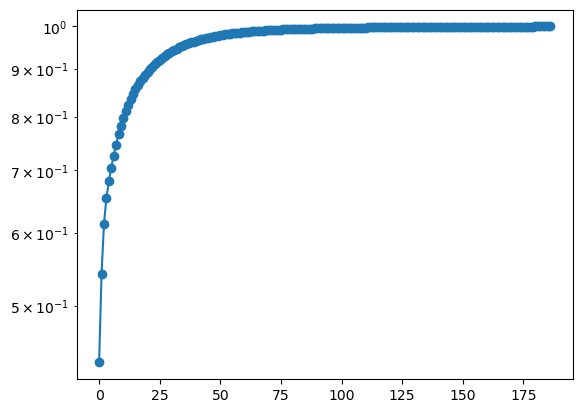

In [26]:
plt.semilogy( np.cumsum(s**2)/np.sum(s**2), '-o')

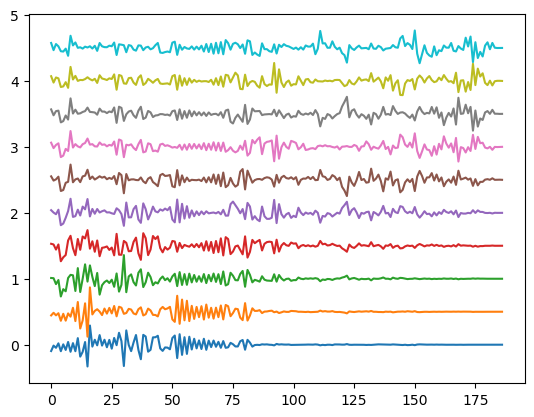

In [54]:
plt.plot(Vt[:,:10] + np.arange(10) * 0.5)
plt.show()

In [143]:
relu     = lambda x: jnp.maximum(0,x)
softmax  = lambda x : jnp.exp(x)/jnp.exp(x).sum()
sigmoide = lambda x: (jnp.tanh(x) + 1.)/2.
@jax.jit
def ANN(params, x):
    layers = []

    weights = params[0::2]
    biases  = params[1::2]
    
    layer = x.copy()
    for W,b in zip(weights[:-1],biases[:-1]):
        layer = relu(W@layer + b)
        
    W,b = weights[-1] , biases[-1]
    layer = W@layer + b
    return layer
batch_ANN = lambda W,X : jax.vmap(lambda x: ANN(W,x))(X)

def init_params(topology):
    params = []
    for t,t_next in zip(topology[:-1],topology[1:]):
        params.append(
            np.random.randn(t_next, t) * 1. / np.sqrt(t * t_next)
        )
        params.append(np.zeros(t_next))
    return params

In [144]:
@jax.jit
def loss(params,x):
    return ((ANN(params,x) - x)**2).sum()
batch_loss = lambda params,X: jax.vmap(lambda x: loss(params,x))(X).mean()
batch_grad = jax.grad(batch_loss)

# train

In [175]:
params = init_params([187,100,20,100,187])
printevery  = 250
X           = jnp.array(X)
for i in range(10 * printevery):
    np.random.seed(i)
    batch = np.random.choice(len(X),16,False)
    gradiente  =  batch_grad(params,X[batch])
    for j in range(len(gradiente)):
        params[j] -= 1e-2 * gradiente[j]
    if i % printevery == 0:
        print(batch_loss(params, X[:1000]))

13.252064
5.9733515
5.896281
3.4596016
3.4052784
3.3729482
3.3860564
3.3865576
3.3614118
3.3655362


In [176]:
len(params)

8

In [177]:
params[int(len(params)/2)].shape

(100, 20)

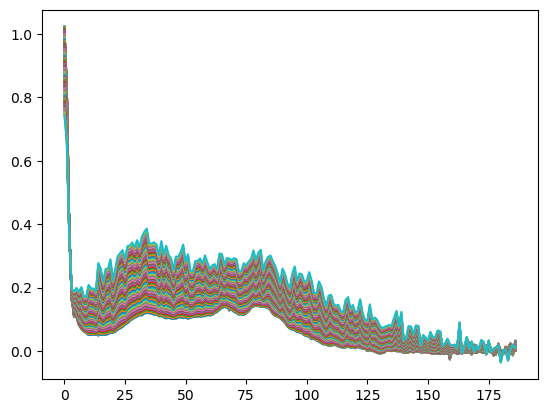

In [182]:
encoder = params[:int(len(params)/2)]
decoder = params[int(len(params)/2):]

decoding = batch_ANN(decoder, (np.linspace(-5,5,100)[:,None]) * np.random.randn( (params[int(len(params)/2)]).shape[1]  ) )
plt.plot(decoding.T)
plt.show()

In [179]:
batch_ANN(encoder,X[:1000])

DeviceArray([[ 0.006479  ,  0.04942714,  0.08468596, ...,  0.03140467,
               0.01375928, -0.01203286],
             [ 0.00293314,  0.01860162,  0.01288487, ...,  0.04047254,
              -0.0055169 , -0.01465791],
             [ 0.0044531 ,  0.04471999,  0.06042472, ...,  0.03379984,
               0.00410715, -0.01394663],
             ...,
             [-0.00266635,  0.12681647,  0.22326505, ...,  0.01153062,
               0.04114499, -0.01041336],
             [ 0.00499329,  0.03105552,  0.03055302, ...,  0.0379917 ,
              -0.00471331, -0.0128247 ],
             [ 0.00067972,  0.06282194,  0.09974989, ...,  0.02932131,
               0.01672542, -0.01109949]], dtype=float32)